# Load packages

In [1]:
# load needed libraries for google colab
!pip install transformers > /dev/null
!pip install datasets > /dev/null

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from transformers import BartModel, BartForSequenceClassification, AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding, BartPretrainedModel
from transformers.modeling_outputs import Seq2SeqSequenceClassifierOutput
from datasets import load_metric
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,f1_score, precision_score
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, auc, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from typing import List, Optional, Tuple, Union
import sklearn.model_selection

from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tokenizer and Model

In [5]:
# load tokenizer and model
device = torch.device(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

checkpoint = 'facebook/bart-large-mnli'

tokenizer = AutoTokenizer.from_pretrained(checkpoint) # transformer AutoTokenizer


In [6]:
class BartClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, d_model, inner_dim, num_classes, dropout):
        super().__init__()
        self.dense = nn.Linear(d_model, inner_dim)
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


In [7]:
class ModifiedBartForSequenceClassification(BartPretrainedModel):
    _tied_weights_keys = ["encoder.embed_tokens.weight", "decoder.embed_tokens.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.model = BartModel(config)

        # Linear layer to map from n*d to d, where n is the number of chunks (currently set to 4)
        self.embedding_fusion_layer = nn.Linear(config.d_model * 4, config.d_model)

        self.classification_head = BartClassificationHead(
            config.d_model,
            config.d_model,
            config.num_labels,
            config.classifier_dropout,
        )
        self.post_init()

    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
        **kwargs
    ):
        # Number of chunks (modify this if the number of chunks changes)
        num_chunks = 4  # <-- MODIFY HERE if you change the number of chunks

        chunk_embeddings = []

        # Process each chunk through the BART model [1,sequence_length]-->> [1,4,chunk_length]
        for i in range(num_chunks):
            outputs_chunk = self.model(input_ids=input_ids[:, i, :], attention_mask=attention_mask[:, i, :], **kwargs)
            chunk_embeddings.append(outputs_chunk[0])

        # Concatenate embeddings from all chunks
        concatenated_embeddings = torch.cat(chunk_embeddings, dim=-1)

        # Pass concatenated embeddings through the fusion layer
        combined_embeddings = self.embedding_fusion_layer(concatenated_embeddings)

        # Extract sentence representation using eos_mask as in the original model
        eos_mask = input_ids.eq(self.config.eos_token_id).reshape(input_ids.shape[0], num_chunks, -1)

        # If no eos_token in the chunk, use the last token's embedding
        lengths = eos_mask.sum(-1).clamp_(0, 1).long() + (eos_mask.sum(-1) == 0).long() * input_ids.shape[2]
        sentence_representation = combined_embeddings[torch.arange(combined_embeddings.shape[0]).unsqueeze(1), lengths-1]

        # Compute logits
        logits = self.classification_head(sentence_representation)

        # If return_dict is False or not set, use the model's configuration
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if not return_dict:
            return logits
        else:
            # Always return a Seq2SeqSequenceClassifierOutput
            return Seq2SeqSequenceClassifierOutput(
                logits=logits,
                past_key_values=None,
                decoder_hidden_states=None,
                decoder_attentions=None,
                cross_attentions=None,
                encoder_last_hidden_state=None,
                encoder_hidden_states=None,
                encoder_attentions=None,
            )





In [8]:
base_nli_model = BartForSequenceClassification.from_pretrained(checkpoint)

# Create an instance of my modified model
nli_model = ModifiedBartForSequenceClassification(base_nli_model.config)

# Transfer the weights
nli_model.model.load_state_dict(base_nli_model.model.state_dict())

<All keys matched successfully>

In [9]:
nli_model.to(device)

ModifiedBartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm

# Read data

In [10]:
# read data
# train_data = pd.read_csv('/kaggle/input/factuality-train/factuality_train_.csv',encoding='ISO-8859-1')  # 读入训练集
# test_data = pd.read_csv('/kaggle/input/factuality-merge/Gen_review_test_factuality_2.csv',encoding='ISO-8859-1')  # 读入测试集

In [11]:
# use merged data
raw_data = pd.read_csv('/content/drive/MyDrive/Internship/Code/codes/Gen_review_factuality.csv')

In [12]:
raw_data.dropna(axis=0, how='any', inplace=True) # drop NA rows

In [13]:
raw_data['label']= raw_data['label'].astype('int')
raw_data.dtypes

pid         object
doc         object
feedback    object
label        int64
dtype: object

In [15]:
train_data, test_data = sklearn.model_selection.train_test_split(
      raw_data, test_size=0.3, random_state=666)  # USE raw_data

# Dataset Preparation

In [16]:
# combines doc and feedback, and breaks it up into overlapping chunks of tokens
def create_chunks(text, hypothesis, chunk_size, overlap, max_chunks=4):
    tokens = tokenizer(text, hypothesis, return_tensors='pt', truncation=True,
                       max_length=chunk_size, padding='max_length', truncation_strategy='only_first')
    stride = chunk_size - overlap
    chunks = []

    for i in range(0, tokens['input_ids'].shape[1] - len(hypothesis), stride):
        chunk = tokens['input_ids'][0, i:i+chunk_size].unsqueeze(0)

        # If the chunk size is less than desired chunk_size, pad it
        if chunk.size(1) < chunk_size:
            padding_size = chunk_size - chunk.size(1)
            padding = torch.full((1, padding_size), tokenizer.pad_token_id, dtype=torch.long)
            chunk = torch.cat([chunk, padding], dim=1)

        chunks.append(chunk)

    # If there are fewer than `max_chunks` chunks, pad the chunks list
    while len(chunks) < max_chunks:
        padding_chunk = torch.full((1, chunk_size), tokenizer.pad_token_id, dtype=torch.long)
        chunks.append(padding_chunk)

    # If there are more than `max_chunks` chunks, truncate the list
    chunks = chunks[:max_chunks]

    return chunks


class FeedbackDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        chunks = create_chunks(row['doc'], row['feedback'], chunk_size=1024, overlap=128)

        # If the chunks result in an empty tensor, print the 'doc' and 'feedback' for debugging
        if chunks[0].nelement() == 0:  # Checking if the first tensor in chunks is empty using nelement()
            print("Problematic doc:", row['doc'])
            print("Problematic feedback:", row['feedback'])

        return {
            'input_ids': chunks,
            'label': row['label']
        }

    def __len__(self):
        return len(self.data)


def collate_batch(batch):
    input_ids_list = [torch.cat(item['input_ids'], dim=1) for item in batch]
    attention_mask_list = [torch.cat([(chunk != tokenizer.pad_token_id).long() for chunk in item['input_ids']], dim=1) for item in batch]
    labels_list = [item['label'] for item in batch]

    input_ids = torch.cat(input_ids_list, dim=0).reshape(-1, 4, 1024).long().to(device)
    attention_mask = torch.cat(attention_mask_list, dim=0).reshape(-1, 4, 1024).long().to(device)
    labels = torch.LongTensor(labels_list).to(device)

    return {
        'input_ids': input_ids.to(device),
        'attention_mask': attention_mask.to(device),
        'labels': labels
    }




# Parameter Configuration

In [ ]:
bs = 1 # set the batch size

learning_rate = 1e-6 # set the initial learning rate

weight_decay = 1e-3 # set the initial weight_decay

num_epochs = 5 # set the number of epochs

weight_ratio = 2.718 # weight adjustment based on the inverse ratio of 0 and 1

# Data Preprocessing

In [17]:
# create Dataset type
train_dataset = FeedbackDataset(train_data)
test_dataset = FeedbackDataset(test_data)

In [18]:
# load data
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, collate_fn=collate_batch, shuffle=True) #  stochastic gradient descent # no order # 8 16
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, collate_fn=collate_batch, shuffle=False)

In [21]:
# weight adjustment for unbalanced data set
weight = torch.tensor([weight_ratio, 1.0])
weight = weight.to(device)
print(weight)

tensor([2.7180, 1.0000], device='cuda:0')


# Model Training

In [22]:
def compute_validation_loss(nli_model, test_loader, loss_fct):
    val_loss = 0
    step = 0
    with torch.no_grad():
        for val_batch in test_loader:
            labels = val_batch.pop("labels")  # Extract labels and remove them from the batch
            outputs = nli_model(**val_batch)
            logits = outputs.get("logits")
            logits = logits[:, [0,2]]

            # compute loss
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))
            step += 1
            val_loss += loss

    val_loss /= step
    return val_loss


def save_best_model(val_loss, min_val_loss, nli_model, best_model_state):
    if val_loss < min_val_loss:
        print(f'Validation loss decreased ({min_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        min_val_loss = val_loss
        best_model_state = copy.deepcopy(nli_model.state_dict())
    return min_val_loss, best_model_state


In [24]:
# train
nli_model.train()

# Initialize the optimizer
optimizer = torch.optim.AdamW(nli_model.parameters(), lr=1e-6, weight_decay=1e-3)

# Initialize the GradScaler for AMP
scaler = GradScaler()

# Initialize the early stopping counter
early_stopping_counter = 0
early_stopping_limit = 2  # Stop training after validation loss has not improved for 2 epochs

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)

# Initialize the minimum validation loss
min_val_loss = float('inf')

# Initialize the minimum average validation loss for early stopping
min_avg_val_loss = float('inf')

# Initialize the best model state
best_model_state = copy.deepcopy(nli_model.state_dict())

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_val_loss = 0.0  # sum of validation loss for the epoch
    val_checks = 0  # number of times validation loss is checked in the epoch

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        labels = batch.pop("labels")  # Extract labels and remove them from the batch

        # Use autocast for the forward pass
        with autocast():
            outputs = nli_model(**batch)
            logits = outputs.get("logits")
            logits = logits[:, [0,2]]  # only take entailment and contradiction, without neutral

            # compute loss
            loss_fct = nn.CrossEntropyLoss(weight=weight)
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        # Use the scaler to scale the loss during backpropagation
        scaler.scale(loss).backward()

        # Use the scaler to step the optimizer and update the scale
        scaler.step(optimizer)
        scaler.update()

        # print average loss every 100 data or 100/bs batch
        running_loss += loss.item()
        if (i+1) % (100/bs) == 0:  # +1 to start counting from 1
            print('[%d, %5d] loss: %.3f' %(epoch+1, (i+1)*bs, running_loss/(100/bs)))
            train_losses.append(running_loss/(100/bs))
            running_loss = 0.0

            # compute validation loss
            val_loss = compute_validation_loss(nli_model, test_loader, loss_fct)
            print("Validation Loss: %.3f" % val_loss)
            valid_losses.append(val_loss.item())

            # Update the learning rate
            scheduler.step(val_loss)

            # Save the best model state
            min_val_loss, best_model_state = save_best_model(val_loss, min_val_loss, nli_model, best_model_state)

            # Add the validation loss to the epoch sum and increment the number of checks
            epoch_val_loss += val_loss
            val_checks += 1

    # After the epoch, check the average validation loss for early stopping
    avg_val_loss = epoch_val_loss / val_checks
    print("Average validation loss for epoch: %.3f" % avg_val_loss)
    if avg_val_loss < min_avg_val_loss:
        min_avg_val_loss = avg_val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_limit:
            print("Early stopping")
            # Load the best state of the model
            nli_model.load_state_dict(best_model_state)
            break

print('Finished Training')


[1,   100] loss: 0.612
Validation Loss: 0.616
Validation loss decreased (inf --> 0.615868).  Saving model ...
[1,   200] loss: 0.683
Validation Loss: 0.594
Validation loss decreased (0.615868 --> 0.593546).  Saving model ...
[1,   300] loss: 0.545
Validation Loss: 0.614
[1,   400] loss: 0.536
Validation Loss: 0.629
[1,   500] loss: 0.641
Validation Loss: 0.584
Validation loss decreased (0.593546 --> 0.584065).  Saving model ...
[1,   600] loss: 0.675
Validation Loss: 0.652
[1,   700] loss: 0.455
Validation Loss: 0.601
[1,   800] loss: 0.652
Validation Loss: 0.586
[1,   900] loss: 0.600
Validation Loss: 0.588
Average validation loss for epoch: 0.607
[2,   100] loss: 0.638
Validation Loss: 0.579
Validation loss decreased (0.584065 --> 0.579282).  Saving model ...
[2,   200] loss: 0.583
Validation Loss: 0.577
Validation loss decreased (0.579282 --> 0.577134).  Saving model ...
[2,   300] loss: 0.521
Validation Loss: 0.583
[2,   400] loss: 0.548
Validation Loss: 0.585
[2,   500] loss: 0.58

In [25]:
print(batch.keys())


dict_keys(['input_ids', 'attention_mask'])


In [26]:
print("input_ids is None:", batch["input_ids"] is None)
print("attention_mask is None:", batch["attention_mask"] is None)


input_ids is None: False
attention_mask is None: False


# Model testing

In [27]:
# test
nli_model.eval()
num_batches = len(test_loader) # The number of the batches
test_loss = 0

test=[] 
prob=[]  
pred=[]  
with torch.no_grad():
    for i,batch in enumerate(test_loader):
        # forward
        labels = batch.pop("labels")
        outputs = nli_model(**batch)
        logits = outputs.get("logits")
        logits= logits[:,[0,2]]
        # compute loss
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        test_loss += loss

        # Softmax normalization
        logits=nn.functional.softmax(logits,dim=1)
        # The probability of predicting as label 1
        prob.extend(logits[:,1].tolist())
        # Choose the largest value of the logits to be the predicted label
        pred.extend(logits.argmax(dim=1).tolist())
        # Ture label
        test.extend(labels.tolist())

    test_loss /= num_batches # loss
print("true labels: ",test)
print("prob: ",prob)
print("predicted labels: ",pred)
print(f"Test: \n Avg loss: {test_loss:>8f} \n")

true labels:  [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0

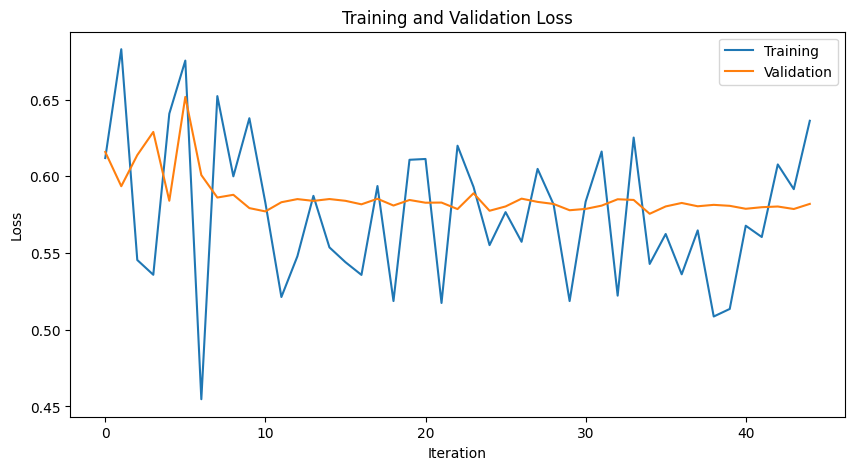

In [28]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(range(len(train_losses)), train_losses, label="Training")
plt.plot(range(len(valid_losses)), valid_losses, label="Validation")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Model Evaluation

In [29]:
print("confusion matrix:\n", confusion_matrix(test,pred))
print("accuracy: ",accuracy_score(test,pred))
print("recall: ",recall_score(test,pred))
print("precison: ", precision_score(test,pred))
print("F1: ",f1_score(test,pred))
print("AUC: ", roc_auc_score(test, prob))

confusion matrix:
 [[  0 116]
 [  0 312]]
accuracy:  0.7289719626168224
recall:  1.0
precison:  0.7289719626168224
F1:  0.8432432432432433
AUC:  0.5755139257294429


In [30]:
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.73      1.00      0.84       312

    accuracy                           0.73       428
   macro avg       0.36      0.50      0.42       428
weighted avg       0.53      0.73      0.61       428



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


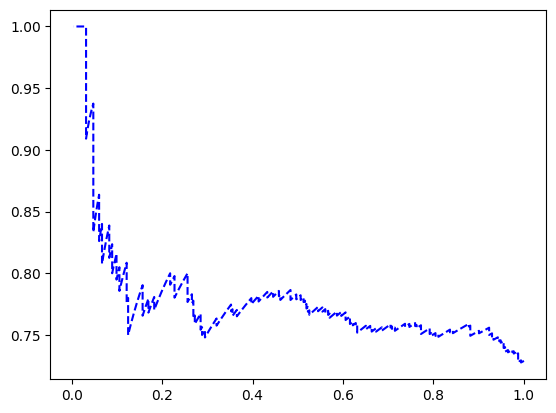

In [31]:

# Plot PR Curve
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'b--')

precisions, recalls, thresholds = precision_recall_curve(test, prob)
plot_precision_recall(precisions, recalls)
plt.show()

In [33]:
pr_auc_score = auc(recalls, precisions)
print(pr_auc_score)

0.7785004582864368
